# Gaussiennes bivariées et visualisation interactive

***
> __Auteur__: Joseph Salmon <joseph.salmon@umontpellier.fr>

Ce widget permet d'investiguer l'impact de la matrice de variance-covariance sur une loi normalle bi-dimensionnelle.

On fixe le paramètre de centrage par simplicité à $(0, 0)$. 

La covariance est paramètrée ici de la manière suivante (décomposition spectrale):

$$\Sigma = \begin{pmatrix}\cos(\theta) & - \sin(\theta)\\  \sin(\theta)& \cos(\theta)\end{pmatrix} \cdot
\begin{pmatrix}\sigma_1 & 0\\ 0 & \sigma_2 \end{pmatrix}
\begin{pmatrix}\cos(\theta) &\sin(\theta)\\  -\sin(\theta)& \cos(\theta)\end{pmatrix}
$$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, multivariate_normal
import ipywidgets
from scipy.spatial import Voronoi, voronoi_plot_2d
from numba import njit, prange

In [2]:
%matplotlib widget


## Visualisation, densité gaussienne (en dimension 2)

In [3]:
def make_box_layout():
    return ipywidgets.Layout(
        border='solid 1px black',
        margin='0px 10px 10px 0px',
        padding='5px 5px 5px 5px',
    )

In [4]:
def covmat_to_scalar(Sigma):
    """Convert covariance matrix to scalars."""
    sigmax = np.sqrt(Sigma[0, 0])
    sigmay = np.sqrt(Sigma[1, 1])
    sigmaxy = Sigma[1, 0]
    return sigmax, sigmay, sigmaxy

@njit()
def angle_scalar_to_covmat(theta, sig1, sig2):
    """Inverse function of the previous one."""
    rotation = np.zeros((2, 2))
    rotation[0, 0] = np.cos(theta)
    rotation[1, 0] = np.sin(theta)
    rotation[0, 1] = -np.sin(theta)
    rotation[1, 1] = np.cos(theta)
    Sigma = rotation.dot(np.eye(2) * np.array([sig1 ** 2, sig2 ** 2])).dot(rotation.T)
    return Sigma

def pdf_2d(Xg, Yg, theta, sig1, sig2):
    Sigma = angle_scalar_to_covmat(theta, sig1, sig2)
    rv = multivariate_normal([0, 0], Sigma)
    pos = np.empty(Xg.shape + (2,))
    pos[:, :, 0] = Xg
    pos[:, :, 1] = Yg
    Z = rv.pdf(pos)
    return Z

In [5]:
@njit()
def boxmuller_multivarn(u, v):
    ncol, nrow = 2, len(u)
    ans = np.zeros((nrow, ncol))
    ans[:, 0] = np.sqrt(-2*np.log(u)) * np.cos(2*np.pi*v)
    ans[:, 1] = np.sqrt(-2*np.log(u)) * np.sin(2*np.pi*v)
    return ans

@njit(parallel=True)
def norm_axis(grid, x, K):
    norm = np.zeros(K)
    for i in prange(K):
        norm[i] =  np.linalg.norm(grid[i, :] -x)
    return norm

@njit()
def CLVQ_quantization(K, theta, sig1, sig2):
    ''' Quantization '''
    Sigma = angle_scalar_to_covmat(theta, sig1, sig2)
    NR = 1000 * K       # number of Monte-Carlo iterations of the algorithm
    a = 4 * np.sqrt(K)  # coef for stochastic gradient
    b = np.pi ** 2 / K  # coef for stochastic gradient
    u, v = np.random.random(K), np.random.random(K)
    grid = boxmuller_multivarn(u, v)
    for nr in range(NR):
        u, v = np.random.random(1), np.random.random(1)        
        x = boxmuller_multivarn(u, v) @ Sigma
        idx = np.argmin(norm_axis(grid, x, K))
        weight = a * (a + b * (nr+1))**-1  # weight for stochastic gradient
        grid[idx] = grid[idx] - weight * (grid[idx]-x)
    return(grid)

points = CLVQ_quantization(K=10, theta=2*np.pi/3, sig1=1, sig2=1)
vor = Voronoi(points)
plt.close()
fig2 = voronoi_plot_2d(vor, show_vertices=False, line_colors='coral', line_width=2, line_alpha=0.5, point_size=5)
plt.show()

In [6]:
class RandomWidgetContinu(ipywidgets.HBox):

    def __init__(self):
        super().__init__()
        output = ipywidgets.Output()
        
        # Init default values for display
        self.theta = 45
        self.theta_radian = self.theta / 180.0 * np.pi  # convertion en radian
        self.sig1 = 2
        self.sig2 = 2
        self.Sigma = angle_scalar_to_covmat(self.theta_radian, self.sig1, self.sig2)
        self.n_samples = 25


        # Init plot (1, 2) for subplots
        with output:
            self.fig, self.ax = plt.subplots(1, 2, sharex=True, sharey=True, constrained_layout=True, figsize=(6.8, 4.4),
                                             num='Gaussiennes: Densité et sa discrétisation par quantification')        
        self.fig.canvas.toolbar_visible = False
        self.xyr = 7
        self.xranges = (-self.xyr, self.xyr)  # Bornes d'affichage
        self.yranges = (-self.xyr, self.xyr)  # Bornes d'affichage
        
        
        # Displays the variance-covariance matrix
        self.my_text_up = self.ax[1].text(-1, self.xyr+1.5, '{sig11:6.2f}   {sig12:6.2f}'.format(sig11=self.Sigma[0, 0], sig12=self.Sigma[1, 0]), size=8, color='black')
        self.my_text_down = self.ax[1].text(-1, self.xyr+.5, '{sig21:6.2f}   {sig22:6.2f}'.format(sig21=self.Sigma[0, 1], sig22=self.Sigma[1, 1]), size=8, color='black')
        self.ax[1].text(-3.5, self.xyr+1, '$\Sigma = $', size=14, color='black')
        self.ax[1].text(-2.5, self.xyr+.5, '$[$', size=50, color='black')
        self.ax[1].text(2.5, self.xyr+.5, '$]$', size=50, color='black')        


        # set 3d plot : density and projection plot
        self.xx = np.linspace(-self.xranges[0], -self.xranges[1], 200)
        self.yy = np.linspace(-self.yranges[0], -self.yranges[1], 200)
        self.Xg, self.Yg = np.meshgrid(self.xx, self.yy)
        Z = pdf_2d(self.Xg, self.Yg, theta=self.theta_radian, sig1=self.sig1, sig2=self.sig2)
        self.ax[0].remove()
        self.ax[0] = self.fig.add_subplot(1, 2, 1, projection='3d')
        self.ax[0].set_zticks([])
        self.ax[0].set_xlabel(r'$x$')
        self.ax[0].set_ylabel(r'$y$')
        self.ax[0].set_xlim(self.xranges)
        self.ax[0].set_ylim(self.yranges)
        self.pdf = self.ax[0].plot_surface(self.Xg, self.Yg, Z, cmap='Oranges', linewidth=0.1, rstride=3, cstride=3, alpha=0.95, lw=0.5, edgecolors='k')
        self.ax[0].set_zlim((-0.2, .75*np.max(Z)))
        ####  Projection plot
        self.pdf1 = self.ax[0].contourf(self.Xg, self.Yg, Z, offset=-0.2, levels=12, cmap='Oranges')
        self.pdf1 = self.ax[0].contour(self.Xg, self.Yg, Z, offset=-0.2, levels=12, linewidths=0.25, colors=['k'])



        # set quantization voronoi plot
        self.samples = CLVQ_quantization(self.n_samples, self.theta, self.sig1, self.sig2)
        #self.ax[1].autoscale(False)  # To avoid that the scatter changes limits
        self.ax[1].set_xlabel(r'$x$')
        self.ax[1].set_ylabel(r'$y$', rotation=0)
        self.vor = voronoi_plot_2d(Voronoi(self.samples), ax=self.ax[1], show_vertices=False, line_colors='coral', line_width=2, line_alpha=0.5, point_size=5)
        self.ax[1].yaxis.set_label_position("right")
        self.ax[1].set_xlim(self.xranges)
        self.ax[1].set_ylim(self.yranges)
        self.ax[1].set_yticks(np.arange(self.xranges[0], self.xranges[1] + 1, 5))
        self.ax[1].set_xticks(np.arange(self.yranges[0], self.yranges[1] + 1, 5))



        # define widgets
        style = {'description_width': '40px'}
        layout = {'width': '215px'}
        n_samples_slider = ipywidgets.IntSlider(value=self.n_samples, description="$K$", style=style, layout=layout,
                                                min=25, max=100, step=25)
        theta_slider = ipywidgets.FloatSlider(value=self.theta, description='$\\theta$', style=style, layout=layout,
                                              min=0, max=360, step=45)
        sig1_slider = ipywidgets.FloatSlider(value=self.sig1, description='$\sigma_1$', style=style, layout=layout,
                                             min=0.5, max=2, step=0.5)
        sig2_slider = ipywidgets.FloatSlider(value=self.sig2, description='$\sigma_2$', style=style, layout=layout,
                                             min=0.5, max=2, step=0.5)
        resample_button = ipywidgets.Button(description="Nouveau tirage",style=style, layout=layout) 
        
        
        
        # Slide box
        controls = ipywidgets.VBox([n_samples_slider, theta_slider,
                                    sig1_slider, sig2_slider, resample_button])
        controls.layout = make_box_layout()
        out_box = ipywidgets.Box([output])
        output.layout = make_box_layout()

        # A Afficher
        n_samples_slider.observe(self.update_n_samples, 'value')
        theta_slider.observe(self.update_theta, 'value')
        sig1_slider.observe(self.update_sig1, 'value')
        sig2_slider.observe(self.update_sig2, 'value')
        resample_button.on_click(self.update_resample_button)

        self.children = [controls, output]

        
        

    def update_theta(self, change):
        """Evolution with the theta parameter."""
        self.theta = change.new
        self.theta_radian = self.theta / 180.0 * np.pi  # convertion en radian
        self.Sigma = angle_scalar_to_covmat(self.theta_radian, self.sig1, self.sig2)
        self.samples = CLVQ_quantization(self.n_samples, self.theta, self.sig1, self.sig2)
        
        #### 3d plot
        Z = pdf_2d(self.Xg, self.Yg, theta=self.theta_radian, sig1=self.sig1, sig2=self.sig2)
        self.pdf.remove()
        self.pdf = self.ax[0].plot_surface(self.Xg, self.Yg, Z, cmap='Oranges', rstride=3, cstride=3, 
                                           alpha=0.95, lw=0.5, edgecolors='k') 
        for coll in self.pdf1.collections:
            coll.remove()
        self.ax[0].set_zlim((-0.2, .75*np.max(Z)))
        self.pdf1 = self.ax[0].contourf(self.Xg, self.Yg, Z, offset=-0.2, levels=12, cmap='Oranges')
        self.pdf1 = self.ax[0].contour(self.Xg, self.Yg, Z, offset=-0.2, levels=12, linewidths=0.25, colors=['k'])
        #### 3d plot
        #### Voronoi plot
        self.ax[1].remove()
        self.ax[1] = self.fig.add_subplot(1, 2, 2)
        self.vor = voronoi_plot_2d(Voronoi(self.samples), ax=self.ax[1], show_vertices=False,
                                   line_colors='coral', line_width=2, line_alpha=0.5, point_size=5)
        # Displays the variance-covariance matrix
        self.my_text_up = self.ax[1].text(-1, self.xyr+1.5, '{sig11:6.2f}   {sig12:6.2f}'.format(sig11=self.Sigma[0, 0], sig12=self.Sigma[1, 0]), size=8, color='black')
        self.my_text_down = self.ax[1].text(-1, self.xyr+.5, '{sig21:6.2f}   {sig22:6.2f}'.format(sig21=self.Sigma[0, 1], sig22=self.Sigma[1, 1]), size=8, color='black')
        self.ax[1].text(-3.75, self.xyr+1, '$\Sigma = $', size=14, color='black')
        self.ax[1].text(-2.5, self.xyr+.5, '$[$', size=50, color='black')
        self.ax[1].text(2.5, self.xyr+.5, '$]$', size=50, color='black')
        self.ax[1].set_xlim(self.xranges)
        self.ax[1].set_ylim(self.yranges)
        #### Voronoi plot
        self.fig.canvas.draw()


    def update_sig1(self, change):
        """Evolution with the sigma1 parameter."""
        self.sig1 = change.new
        self.Sigma = angle_scalar_to_covmat(self.theta_radian, self.sig1, self.sig2)
        self.samples = CLVQ_quantization(self.n_samples, self.theta, self.sig1, self.sig2)
        
        self.my_text_up.set_text('{sig11:6.2f}   {sig12:6.2f}'.format(sig11=self.Sigma[0, 0],
                                                                      sig12=self.Sigma[1, 0]))
        self.my_text_down.set_text('{sig21:6.2f}   {sig22:6.2f}'.format(sig21=self.Sigma[0, 1],
                                                                        sig22=self.Sigma[1, 1]))

        #### 3d plot
        Z = pdf_2d(self.Xg, self.Yg, theta=self.theta_radian, sig1=self.sig1, sig2=self.sig2)
        self.pdf.remove()
        self.pdf = self.ax[0].plot_surface(self.Xg, self.Yg, Z, cmap='Oranges', rstride=3, cstride=3,
                                           alpha=0.95, lw=0.5, edgecolors='k') 
        for coll in self.pdf1.collections:
            coll.remove()
        self.ax[0].set_zlim((-0.2, .75*np.max(Z)))
        self.pdf1 = self.ax[0].contourf(self.Xg, self.Yg, Z, offset=-0.2, levels=12, cmap='Oranges')
        self.pdf1 = self.ax[0].contour(self.Xg, self.Yg, Z, offset=-0.2, levels=12, linewidths=0.25, colors=['k'])
        #### 3d plot        
        #### Voronoi plot
        self.ax[1].remove()
        self.ax[1] = self.fig.add_subplot(1, 2, 2)
        self.vor = voronoi_plot_2d(Voronoi(self.samples), ax=self.ax[1], show_vertices=False,
                                   line_colors='coral', line_width=2, line_alpha=0.5, point_size=5)
        # Displays the variance-covariance matrix
        self.my_text_up = self.ax[1].text(-1, self.xyr+1.5, '{sig11:6.2f}   {sig12:6.2f}'.format(sig11=self.Sigma[0, 0], sig12=self.Sigma[1, 0]), size=8, color='black')
        self.my_text_down = self.ax[1].text(-1, self.xyr+.5, '{sig21:6.2f}   {sig22:6.2f}'.format(sig21=self.Sigma[0, 1], sig22=self.Sigma[1, 1]), size=8, color='black')
        self.ax[1].text(-3.75, self.xyr+1, '$\Sigma = $', size=14, color='black')
        self.ax[1].text(-2.5, self.xyr+.5, '$[$', size=50, color='black')
        self.ax[1].text(2.5, self.xyr+.5, '$]$', size=50, color='black')
        self.ax[1].set_xlim(self.xranges)
        self.ax[1].set_ylim(self.yranges)
        self.fig.canvas.draw()
        #### Voronoi plot



        
    def update_sig2(self, change):
        """Evolution with the sigma1 parameter."""
        self.sig2 = change.new
        self.Sigma = angle_scalar_to_covmat(self.theta_radian, self.sig1, self.sig2)
        self.samples = CLVQ_quantization(self.n_samples, self.theta, self.sig1, self.sig2)
        
        self.my_text_up.set_text('{sig11:6.2f}    {sig12:6.2f}'.format(sig11=self.Sigma[0, 0],
                                                                       sig12=self.Sigma[1, 0]))
        self.my_text_down.set_text('{sig21:6.2f}    {sig22:6.2f}'.format(sig21=self.Sigma[0, 1],
                                                                         sig22=self.Sigma[1, 1]))
        #### 3d plot
        Z = pdf_2d(self.Xg, self.Yg, theta=self.theta_radian, sig1=self.sig1, sig2=self.sig2)
        self.pdf.remove()
        self.pdf = self.ax[0].plot_surface(self.Xg, self.Yg, Z, cmap='Oranges', rstride=3, cstride=3,
                                           alpha=0.95, lw=0.5, edgecolors='k') 
        for coll in self.pdf1.collections:
            coll.remove()
        self.ax[0].set_zlim((-0.2, .75*np.max(Z)))
        self.pdf1 = self.ax[0].contourf(self.Xg, self.Yg, Z, offset=-0.2, levels=12, cmap='Oranges')
        self.pdf1 = self.ax[0].contour(self.Xg, self.Yg, Z, offset=-0.2, levels=12, linewidths=0.25, colors=['k'])
        #### 3d plot 
        #### Voronoi plot
        self.ax[1].remove()
        self.ax[1] = self.fig.add_subplot(1, 2, 2)
        self.vor = voronoi_plot_2d(Voronoi(self.samples), ax=self.ax[1], show_vertices=False,
                                   line_colors='coral', line_width=2, line_alpha=0.5, point_size=5)
        # Displays the variance-covariance matrix
        self.my_text_up = self.ax[1].text(-1, self.xyr+1.5, '{sig11:6.2f}   {sig12:6.2f}'.format(sig11=self.Sigma[0, 0], sig12=self.Sigma[1, 0]), size=8, color='black')
        self.my_text_down = self.ax[1].text(-1, self.xyr+.5, '{sig21:6.2f}   {sig22:6.2f}'.format(sig21=self.Sigma[0, 1], sig22=self.Sigma[1, 1]), size=8, color='black')
        self.ax[1].text(-3.75, self.xyr+1, '$\Sigma = $', size=14, color='black')
        self.ax[1].text(-2.5, self.xyr+.5, '$[$', size=50, color='black')
        self.ax[1].text(2.5, self.xyr+.5, '$]$', size=50, color='black')
        self.ax[1].set_xlim(self.xranges)
        self.ax[1].set_ylim(self.yranges)
        self.fig.canvas.draw()
        #### Voronoi plot      



    def update_n_samples(self, change):
        """Evolution with the n_samples parameter."""
        self.n_samples = change.new
        self.samples = CLVQ_quantization(self.n_samples, self.theta, self.sig1, self.sig2)
        #### Voronoi plot
        self.ax[1].remove()
        self.ax[1] = self.fig.add_subplot(1, 2, 2)
        self.vor = voronoi_plot_2d(Voronoi(self.samples), ax=self.ax[1], show_vertices=False,
                                   line_colors='coral', line_width=2, line_alpha=0.5, point_size=5)
        # Displays the variance-covariance matrix
        self.my_text_up = self.ax[1].text(-1, self.xyr+1.5, '{sig11:6.2f}   {sig12:6.2f}'.format(sig11=self.Sigma[0, 0], sig12=self.Sigma[1, 0]), size=8, color='black')
        self.my_text_down = self.ax[1].text(-1, self.xyr+.5, '{sig21:6.2f}   {sig22:6.2f}'.format(sig21=self.Sigma[0, 1], sig22=self.Sigma[1, 1]), size=8, color='black')
        self.ax[1].text(-3.75, self.xyr+1, '$\Sigma = $', size=14, color='black')
        self.ax[1].text(-2.5, self.xyr+.5, '$[$', size=50, color='black')
        self.ax[1].text(2.5, self.xyr+.5, '$]$', size=50, color='black')
        self.ax[1].set_xlim(self.xranges)
        self.ax[1].set_ylim(self.yranges)       
        self.fig.canvas.draw()
        #### Voronoi plot

    def update_resample_button(self, change):
        self.samples = CLVQ_quantization(self.n_samples, self.theta, self.sig1, self.sig2)
        #### Voronoi plot
        self.ax[1].remove()
        self.ax[1] = self.fig.add_subplot(1, 2, 2)
        self.vor = voronoi_plot_2d(Voronoi(self.samples), ax=self.ax[1], show_vertices=False,
                                   line_colors='coral', line_width=2, line_alpha=0.5, point_size=5)
        # Displays the variance-covariance matrix
        self.my_text_up = self.ax[1].text(-1, self.xyr+1.5, '{sig11:6.2f}   {sig12:6.2f}'.format(sig11=self.Sigma[0, 0], sig12=self.Sigma[1, 0]), size=8, color='black')
        self.my_text_down = self.ax[1].text(-1, self.xyr+.5, '{sig21:6.2f}   {sig22:6.2f}'.format(sig21=self.Sigma[0, 1], sig22=self.Sigma[1, 1]), size=8, color='black')
        self.ax[1].text(-3.75, self.xyr+1, '$\Sigma = $', size=14, color='black')
        self.ax[1].text(-2.5, self.xyr+.5, '$[$', size=50, color='black')
        self.ax[1].text(2.5, self.xyr+.5, '$]$', size=50, color='black')
        self.ax[1].set_xlim(self.xranges)
        self.ax[1].set_ylim(self.yranges)
        self.fig.canvas.draw()
        #### Voronoi plot

        
    def update_xrange_slider(self, change):
        self.xranges = change.new
        self.pdf.set_ydata(self.distribution.pdf(self.x, loc=self.mu, scale=self.sigma))
        self.ax[0].set_xlim(self.xranges)
        self.ax[1].set_xlim(self.xranges)
        self.fig.canvas.draw()

    def update_yrange_slider_pdf(self, change):
        self.yranges_pdf = change.new
        self.ax[0].set_ylim(self.yranges_pdf)
        self.fig.canvas.draw()

    def update_text_distribution(self, change):
        self.distribution = distributions_0_dict[change.new]
        self.pdf.set_ydata(self.distribution.pdf(self.x, loc=self.mu, scale=self.sigma))
        self.samples = self.distribution.rvs(size=self.n_samples, loc=self.mu, scale=self.sigma)
        self.fig.canvas.draw()

RandomWidgetContinu(children=(VBox(children=(IntSlider(value=25, description='$K$', layout=Layout(width='215px…

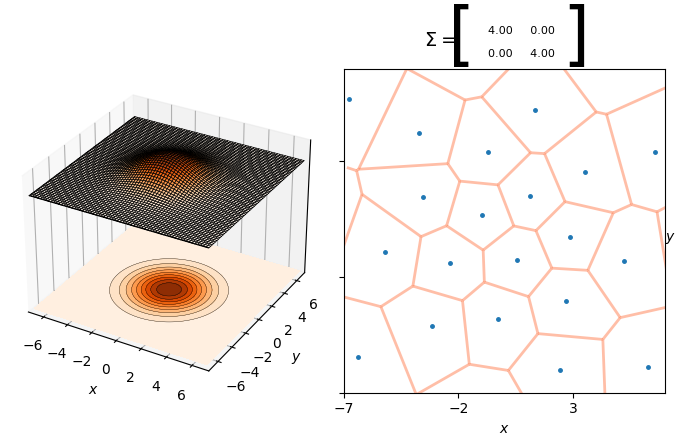

In [7]:
RandomWidgetContinu()